In [1]:
import warnings
warnings.filterwarnings('ignore')

# Clustering

In [2]:
import pandas as pd

df = pd.DataFrame([[1, '01-03-2022', 300],
                   [2, '01-03-2022', 2000],
                   [2, '01-04-2022', 500],
                   [6, '02-06-2022', 200],
                   [5, '02-17-2022', 1200],
                   [3, '02-25-2022', 3000],
                   [1, '03-20-2022', 250],
                   [3, '03-22-2022', 300],
                   [2, '03-26-2022', 1750],
                   [4, '03-28-2022', 600]
                  ],
                  columns = ['CustomerID', 'InvoiceDate', 'InvoiceAmount']
                 )
df

,CustomerID,InvoiceDate,InvoiceAmount
0,1,01-03-2022,300
1,2,01-03-2022,2000
2,2,01-04-2022,500
3,6,02-06-2022,200
4,5,02-17-2022,1200
5,3,02-25-2022,3000
6,1,03-20-2022,250
7,3,03-22-2022,300
8,2,03-26-2022,1750
9,4,03-28-2022,600


In [3]:
# Feature Engineering
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
gb = df.groupby('CustomerID')
counts = gb.size().to_frame(name = 'Frequency')
dfRFM = \
(counts
    .join(gb.agg({'InvoiceDate': 'max'}).rename(columns={'InvoiceDate': 'MostRecentPurchase'}))
    .join(gb.agg({'InvoiceAmount': 'sum'}).rename(columns={'InvoiceAmount': 'MonetaryValue'}))
    .reset_index()
)

#from datetime import datetime, date
dfRFM['MostRecentPurchaseDate'] = pd.to_datetime(dfRFM['MostRecentPurchase']).dt.date
dfRFM['Recency'] = (df.InvoiceDate.max().date() - dfRFM['MostRecentPurchaseDate']).dt.days
dfRFM.drop(['MostRecentPurchaseDate', 'MostRecentPurchase'], axis = 1, inplace = True)
print('Shape of Customer Data:', dfRFM.shape)
print('\n')
print(dfRFM.head())

Shape of Customer Data: (6, 4)


   CustomerID  Frequency  MonetaryValue  Recency
0           1          2            550        8
1           2          3           4250        2
2           3          2           3300        6
3           4          1            600        0
4           5          1           1200       39


In [4]:
# Scale Data
X = dfRFM.drop('CustomerID', axis = 1, inplace = False)
y = dfRFM['CustomerID']

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X.to_numpy())
X = pd.DataFrame(X, columns=['Frequency', 'MonetaryValue', 'Recency'])
X.head()

,Frequency,MonetaryValue,Recency
0,0.447214,-0.739480,-0.486540
1,1.788854,1.674705,-0.793829
2,0.447214,1.054846,-0.588970
3,-0.894427,-0.706856,-0.896258
4,-0.894427,-0.315366,1.101117


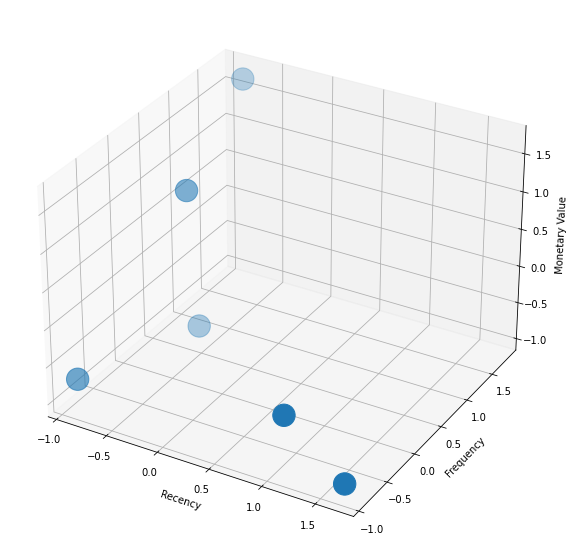

In [5]:
# Visualise the Data
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

np.random.seed(19680801)

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(projection = '3d')

xs = X.Recency
ys = X.Frequency
zs = X.MonetaryValue
ax.scatter(xs, ys, zs, marker = 'o', s = 500, label = y)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary Value')

plt.show()

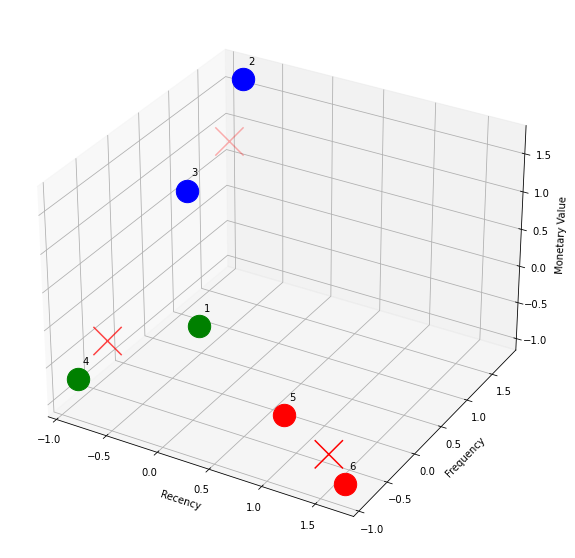

In [6]:
# Create Clusters
from sklearn.cluster import KMeans
import matplotlib.transforms as mtransforms

kmeans = KMeans(n_clusters = 3, random_state = 42)
kmeans.fit(X, y)

# Visualise
np.random.seed(19680801)

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(projection = '3d')

colours = ['r', 'b', 'g']
dfTemp = pd.DataFrame({'Recency':xs, 
                       'Frequency':ys, 
                       'MonetaryValue':zs, 
                       'CustomerID':y, 
                       'Cluster':kmeans.labels_}
                       )
dfTemp = dfTemp.reset_index()  # make sure indexes pair with number of rows
trans_offset = mtransforms.offset_copy(ax.transData, fig = fig,
                                       x = 0.07, y = 0.2, units = 'inches')

for index, row in dfTemp.iterrows():
    ax.scatter(row['Recency'], row['Frequency'], row['MonetaryValue'], marker = 'o', s = 500, c = colours[int(row['Cluster'])])
    ax.text(row['Recency'], row['Frequency'], row['MonetaryValue'], int(row['CustomerID']), transform = trans_offset)

xs1 = kmeans.cluster_centers_.T[2]
ys1 = kmeans.cluster_centers_.T[1]
zs1 = kmeans.cluster_centers_.T[0]
ax.scatter(xs1, ys1, zs1, marker = 'x', s = 800, c = 'r')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary Value')

plt.show()